In [ ]:
!pip install -q seaborn
!pip install -q git+https://github.com/tensorflow/docs

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

I'm making this project with TensorFlow 2.0 so I need to specify that for Google Colab since it should be compatible with Colab.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Importing required libraries

In [2]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data'

dataset_path = tf.keras.utils.get_file("train.csv", data_url)

column_names = ['Name','Landmass','Zone','Area','Population', 'Language', 
                'Religion', 'Bars', 'Stripes', 'Colours', 'Red', 'Green', 
                'Blue', 'Gold', 'White', 'Black', 'Orange', 'Main Hue',
                'Circles', 'Crosses', 'Saltires', 'Quarters', 'Sunstars',
                'Crescent', 'Triangle', 'Icon', 'Animate', 'Text', 'Top Left',
                'Bottom Right']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "Unknown", sep=",")

raw_dataset.tail()

,Name,Landmass,Zone,Area,Population,Language,Religion,Bars,Stripes,Colours,...,Saltires,Quarters,Sunstars,Crescent,Triangle,Icon,Animate,Text,Top Left,Bottom Right
189,Western-Samoa,6,3,3,0,1,1,0,0,3,...,0,1,5,0,0,0,0,0,blue,red
190,Yugoslavia,3,1,256,22,6,6,0,3,4,...,0,0,1,0,0,0,0,0,blue,red
191,Zaire,4,2,905,28,10,5,0,0,4,...,0,0,0,0,0,1,1,0,green,green
192,Zambia,4,2,753,6,10,5,3,0,4,...,0,0,0,0,0,0,1,0,green,brown
193,Zimbabwe,4,2,391,8,10,5,0,7,5,...,0,0,1,0,1,1,1,0,green,green


In [3]:
dataset = raw_dataset.copy()

dataset = dataset.drop(['Name', 'Area', 'Landmass', 'Population', 'Bars', 
                        'Red', 'Green', 'Blue', 'Gold', 
                        'White', 'Black', 'Orange', 'Main Hue', 'Circles', 'Crosses', 
                        'Saltires', 'Quarters', 'Crescent', 'Triangle', 
                        'Top Left', 'Bottom Right'], axis = 1)

dataset.tail()

,Zone,Language,Religion,Stripes,Colours,Sunstars,Icon,Animate,Text
189,3,1,1,0,3,5,0,0,0
190,1,6,6,3,4,1,0,0,0
191,2,10,5,0,4,0,1,1,0
192,2,10,5,0,4,0,0,1,0
193,2,10,5,7,5,1,1,1,0


In [4]:
train_dataset = dataset
train_dataset = train_dataset.drop('Religion', axis = 1)

train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

train_labels = dataset['Religion']
print(train_labels)
print(train_dataset.tail())
religion_dict = ['Catholic', 'Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic', 'Marxist', 'Others']

0      2
1      6
2      2
3      1
4      0
      ..
189    1
190    6
191    5
192    5
193    5
Name: Religion, Length: 194, dtype: int64
     Zone  Language  Stripes  Colours  Sunstars  Icon  Animate  Text
189     3         1        0        3         5     0        0     0
190     1         6        3        4         1     0        0     0
191     2        10        0        4         0     1        1     0
192     2        10        0        4         0     0        1     0
193     2        10        7        5         1     1        1     0


In [5]:
def build_model():
  model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(train_dataset), activation='softmax')
  ])

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                metrics=['sparse_categorical_crossentropy'])
  return model

model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 194)               12610     
Total params: 17,346
Trainable params: 17,346
Non-trainable params: 0
_________________________________________________________________


In [6]:
# example_batch = train_dataset[:10]
# example_result = model.predict(example_batch)
# print(example_result)

EPOCHS = 2500

history = model.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split = 0.2, callbacks=[tfdocs.modeling.EpochDots()])

arse_categorical_crossentropy: 0.1512 - val_loss: 5.6279 - val_sparse_categorical_crossentropy: 5.6279
Epoch 2401/2500
 32/155 [=====>........................] - ETA: 0s - loss: 0.1008 - sparse_categorical_crossentropy: 0.1008
Epoch: 2400, loss:0.1584,  sparse_categorical_crossentropy:0.1584,  val_loss:5.6175,  val_sparse_categorical_crossentropy:5.6175,  
155/155 [==============================] - 0s 103us/sample - loss: 0.1584 - sparse_categorical_crossentropy: 0.1584 - val_loss: 5.6175 - val_sparse_categorical_crossentropy: 5.6175
Epoch 2402/2500
155/155 [==============================] - 0s 90us/sample - loss: 0.1554 - sparse_categorical_crossentropy: 0.1554 - val_loss: 5.6284 - val_sparse_categorical_crossentropy: 5.6284
Epoch 2403/2500
155/155 [==============================] - 0s 90us/sample - loss: 0.1510 - sparse_categorical_crossentropy: 0.1510 - val_loss: 5.6391 - val_sparse_categorical_crossentropy: 5.6391
Epoch 2404/2500
155/155 [==============================] - 0s 110us/

Text(0, 0.5, 'sparse_categorical_crossentropy')

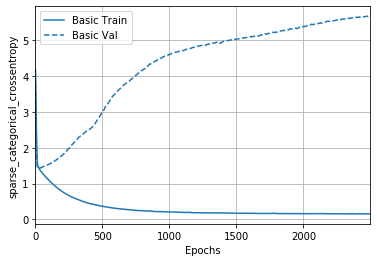

In [7]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
# print(hist.tail())

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "sparse_categorical_crossentropy")
# plt.ylim([0, 20])
plt.ylabel('sparse_categorical_crossentropy')

In [8]:
print("Now, it's time to predict!")
predZone = input("In which geographic quadrant (based on Greenwich and the Equator) is that country? (Enter 1 for North-East, 2 for South-East, 3 for South-West and 4 for North-West)")
predLang = input("What language is being spoken in that country? (1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others)")
predStripes = input("How many stripes are there in that country's flag?")
predColours = input("How many DIFFERENT colours are there in that country's flag?")
predSunStars = input("How many suns or stars are there in that country's flag?")
predIcon = input("Are there any kind of inanimate images (e.g., a boat) on that country's flag? (Type 1 for yes, 0 for no)")
predAnimate = input("Are there any kind of animate images (e.g., an eagle, a tree, a human hand) on that country's flag? (Type 1 for yes, 0 for no)")
predText = input("Are there any letters or writing on the flag (e.g., a motto or slogan) on that country's flag? (Type 1 for yes, 0 for no)")
predData = [predZone, predLang, predStripes, predColours, predSunStars, predIcon, predAnimate, predText]
prediction = model.predict(predData)

Now, it's time to predict!


StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.